In [102]:
import numpy as np
import pandas as pd
rng = np.random.default_rng(42)

from lymph.models import Unilateral
from lymixture import LymphMixture
from lymixture.utils import binom_pmf, late_binomial, normalize

dataset = pd.read_csv('../../data/mixture_model_data_combined.csv', header = [0,1,2],)
dataset_staging = dataset.copy()
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([0,1,2], 'early')
dataset_staging['tumor','1','t_stage'] = dataset_staging['tumor','1','t_stage'].replace([3,4], 'late')
dataset_staging = dataset_staging[~(dataset_staging['tumor']['1']['subsite'].str.startswith(('C00.4')))]

In [91]:
dataset_staging_main_groups = dataset_staging.copy()

# Reduce to only main subsite
dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')] = (
    dataset_staging_main_groups.loc[:, ('tumor', '1', 'subsite')].str.replace(r'\..*', '', regex=True)
)

dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()


subsite
C09    452
C12    227
C01    212
C10    169
C13    165
C02    158
C04     99
C05     61
C06     46
C03     45
Name: count, dtype: int64

In [92]:
graph = {
    ("tumor", "T"): ["I", "II", "III", "IV", "V"],
    ("lnl", "I"): ["II"],
    ("lnl", "II"): ["III"],
    ("lnl", "III"): ["IV"],
    ("lnl", "IV"): ["V"],
    ("lnl", "V"): [],
}

num_components = 3

mixture = LymphMixture(
    model_cls=Unilateral,
    model_kwargs={"graph_dict": graph},
    num_components=num_components,
    universal_p= False
)
mixture.load_patient_data(
    dataset_staging_main_groups,
    split_by=("tumor", "1", "subsite"),
    mapping=lambda x: x,
)


In [93]:
mixture.set_distribution("early", binom_pmf(np.arange(11), 10, 0.3))
mixture.set_distribution("late", late_binomial)
mixture.set_modality("diagnostic_consensus", 1., 1.)

In [94]:
mixture.subgroups.keys()

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C09', 'C10', 'C12', 'C13'])

Initialize random model parameters and latent variables/responsibilities.

In [103]:
from lymixture.em import expectation, maximization

params = {k: rng.uniform() for k in mixture.get_params()}

mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [96]:
def to_numpy(params: dict[str, float]) -> np.ndarray:
    return np.array([p for p in params.values()])

In [104]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.281875,0.487351,0.366537,0.442804,0.274028,0.189771,0.485022,0.057583,0.692963,0.446088
1,0.566157,0.508777,0.185485,0.199379,0.290183,0.158230,0.113625,0.429235,0.189988,0.473030
2,0.151967,0.003872,0.447978,0.357818,0.435789,0.651999,0.401353,0.513182,0.117050,0.080882


Iterate the computation of the expectation value of the latent variables (E-step) and the maximization of the (complete) data log-likelihood w.r.t. the model parameters (M-step).

In [105]:
def check_convergence(params_history, likelihood_history, steps_back_list):
    current_params = params_history[-1]
    current_likelihood = likelihood_history[-1]
    for steps_back in steps_back_list:
        previous_params = params_history[-steps_back - 1]
        if np.allclose(to_numpy(current_params), to_numpy(previous_params)):
            print('stopped due to parameter similarity')
            return True  # Return True if any of the steps is close
        elif (np.isclose(current_likelihood, likelihood_history[-steps_back - 1],rtol = 0, atol = 0.01)) and np.all(current_likelihood >= np.array(likelihood_history)):
            print('stopped due to likelihood similarity')
            return True
    return False

In [106]:
is_converged = False
count = 0
params_history = []
likelihood_history = []
params_history.append(params.copy())
likelihood_history.append(mixture.likelihood(use_complete=False))
# Number of steps to look back for convergence
look_back_steps = 3

while not is_converged:
    print(count)
    print(likelihood_history[-1])
    old_params = params
    latent = expectation(mixture, params)
    params = maximization(mixture, latent)
    
    # Append current params and likelihood to history
    params_history.append(params.copy())
    likelihood_history.append(mixture.likelihood(use_complete=False))
    
    # Check if converged
    if count >= 3:  # Ensure enough history is available
        is_converged = check_convergence(params_history, likelihood_history,list(range(1,look_back_steps+1)))
    count += 1

0
-8861.149052667717
1
-3457.443680231825
2
-3429.300770722326
3
-3407.9617660499785
4
-3378.641010454833
5
-3336.734531417028
6
-3297.4312294650545
7
-3273.848159632145
8
-3261.832001797866
9
-3255.8830846501305
10
-3252.147239400156
11
-3249.1842524015105
12
-3246.591464706784
13
-3244.249503116841
14
-3242.0992888761652
15
-3240.1780368271707
16
-3238.415688016317
17
-3236.8017858449703
18
-3235.317264193238
19
-3233.937328989603
20
-3232.6497119883215
21
-3231.439432377087
22
-3230.298153448658
23
-3229.2246576573452
24
-3228.211954390273
25
-3227.2585199525065
26
-3226.3651994288684
27
-3225.5267715365535
28
-3224.7434015456724
29
-3224.0109591708147
30
-3223.326577144933
31
-3222.6892374498043
32
-3222.0954696814733
33
-3221.5426498846255
34
-3221.0080211763916
35
-3220.492038025968
36
-3220.0157560471393
37
-3219.5574432768003
38
-3219.1144733640012
39
-3218.6994881244063
40
-3218.2947353335903
41
-3217.914010291013
42
-3217.554403333669
43
-3217.2113479765403
44
-3216.893949423

In [107]:
likelihood_history

[-8861.149052667717,
 -3457.443680231825,
 -3429.300770722326,
 -3407.9617660499785,
 -3378.641010454833,
 -3336.734531417028,
 -3297.4312294650545,
 -3273.848159632145,
 -3261.832001797866,
 -3255.8830846501305,
 -3252.147239400156,
 -3249.1842524015105,
 -3246.591464706784,
 -3244.249503116841,
 -3242.0992888761652,
 -3240.1780368271707,
 -3238.415688016317,
 -3236.8017858449703,
 -3235.317264193238,
 -3233.937328989603,
 -3232.6497119883215,
 -3231.439432377087,
 -3230.298153448658,
 -3229.2246576573452,
 -3228.211954390273,
 -3227.2585199525065,
 -3226.3651994288684,
 -3225.5267715365535,
 -3224.7434015456724,
 -3224.0109591708147,
 -3223.326577144933,
 -3222.6892374498043,
 -3222.0954696814733,
 -3221.5426498846255,
 -3221.0080211763916,
 -3220.492038025968,
 -3220.0157560471393,
 -3219.5574432768003,
 -3219.1144733640012,
 -3218.6994881244063,
 -3218.2947353335903,
 -3217.914010291013,
 -3217.554403333669,
 -3217.2113479765403,
 -3216.8939494235933,
 -3216.598816673443,
 -3216.32

In [108]:
# a = np.array(likelihood_history)
# np.savetxt('likelihoods_3_comp_t_stage_new.txt', a, fmt='%.6f')
b = np.loadtxt('likelihoods_3_comp_t_stage_new.txt', dtype=float)
b


FileNotFoundError: likelihoods_3_comp_t_stage_new.txt not found.

In [109]:
differences = []
for i in range(len(params_history)-1):
    differences.append(np.abs(np.array(list(params_history[i].values())) - np.array(list(params_history[i+1].values()))).sum())
differences

[24.43162161614799,
 1.666686978531569,
 1.336110362721769,
 1.4675629832925035,
 1.9186646529454765,
 2.376928232266133,
 1.9769210123675185,
 1.3496425371618281,
 0.820322903369987,
 0.5022227074264299,
 0.36696754489295763,
 0.31254553881244734,
 0.2895998496520673,
 0.27464144579790206,
 0.25105130214856897,
 0.2416624226215413,
 0.23451393029671153,
 0.22727006829188073,
 0.2256281382637627,
 0.2238237683591441,
 0.21946019453077772,
 0.21295282259414502,
 0.20547726932606614,
 0.19680468891844533,
 0.18875019972990414,
 0.18000755681860126,
 0.1700675108104997,
 0.16124987984647624,
 0.1515596676359723,
 0.14355908200541145,
 0.13558190891194757,
 0.1274232283353071,
 0.12007004658097062,
 0.11391812703824492,
 0.11225669265011129,
 0.11408407893621952,
 0.11424173218345594,
 0.11547733494490703,
 0.11695488642605958,
 0.11713121933812609,
 0.11796372309036388,
 0.11726436060462908,
 0.11527172687371082,
 0.11310415656174175,
 0.10972034563004372,
 0.10545745363185703,
 0.1002613

Text(0.5, 1.0, 'Convergence of EM algorithm 3 comp 3 locs')

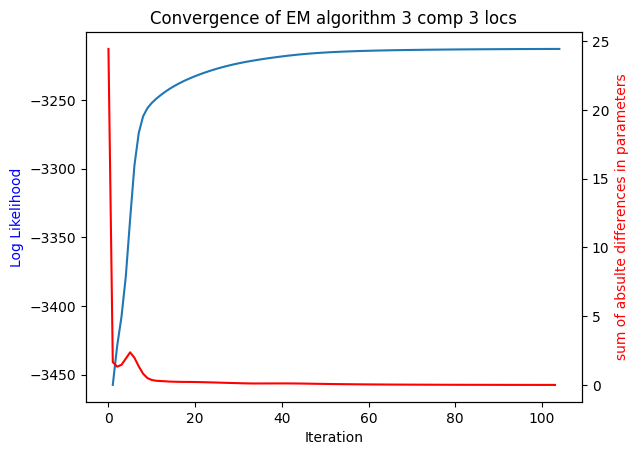

In [110]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.plot(np.array(range(len(likelihood_history[1:])))+1,likelihood_history[1:])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log Likelihood', color='blue')
ax2 = ax1.twinx()
ax2.plot(differences, color='red')  
ax2.set_ylabel('sum of absulte differences in parameters', color='red')
ax1.set_title('Convergence of EM algorithm 3 comp 3 locs')

In [113]:
params = params_history[np.argmax(likelihood_history)]
mixture.set_params(**params)
mixture.normalize_mixture_coefs()
latent = normalize(rng.uniform(size=mixture.get_resps().shape).T, axis=0).T

In [114]:
mixture.likelihood(use_complete=False)

-3212.83105259941

In [116]:
mixture._mixture_coefs

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,0.019298,0.084692,1.575820e-45,0.038606,0.016485,4.819100e-11,0.061634,0.278769,9.841338e-01,0.965111
1,0.000700,0.625650,1.000000e+00,0.855093,0.525133,9.563146e-01,0.063317,0.199839,9.006378e-12,0.000002
2,0.980002,0.289658,8.121103e-26,0.106301,0.458383,4.368543e-02,0.875048,0.521393,1.586620e-02,0.034887


In [118]:
mixture.get_params()

{'0_TtoI_spread': 0.011839495996419392,
 '0_TtoII_spread': 0.27880027938392543,
 '0_TtoIII_spread': 0.1417551109069473,
 '0_TtoIV_spread': 0.047973036838307316,
 '0_TtoV_spread': 0.030181252827605004,
 '0_ItoII_spread': 0.5806896118822662,
 '0_IItoIII_spread': 0.29737035711045673,
 '0_IIItoIV_spread': 0.07732147260149481,
 '0_IVtoV_spread': 0.09633384983871933,
 '0_late_p': 0.37400426404678855,
 '0_C01_coef': 0.01929813686182817,
 '0_C02_coef': 0.08469237172928433,
 '0_C03_coef': 1.5758203363079556e-45,
 '0_C04_coef': 0.03860614144130741,
 '0_C05_coef': 0.01648460202823512,
 '0_C06_coef': 4.8190999896168166e-11,
 '0_C09_coef': 0.06163446844938796,
 '0_C10_coef': 0.2787686379813326,
 '0_C12_coef': 0.9841337979921385,
 '0_C13_coef': 0.9651113772210862,
 '1_TtoI_spread': 0.061073300289168304,
 '1_TtoII_spread': 0.024264589402229867,
 '1_TtoIII_spread': 0.013793463836453388,
 '1_TtoIV_spread': 0.003904726612294047,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.1639191368608

In [65]:
subgroup = 'C13'
t_stage = 'late'
desired_lnl = 'II'
lnls = np.array(['I','II','III','IV','V'])
involvement = {'I': None, 'II': None, 'III': None, 'IV': None, 'V': None}



subgroup_combinations_short = pd.DataFrame(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].loc[mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage].value_counts()/((mixture.subgroups[subgroup].patient_data['_model']['#']['t_stage'] == t_stage) & (np.all(mixture.subgroups[subgroup].patient_data['_model']['diagnostic_consensus'].notna(),axis = 1))).sum().sum())
# Convert the Series to DataFrame
df = subgroup_combinations_short.reset_index()
df.columns = ['I', 'II', 'III', 'IV', 'V', 'prevalence']

# Convert boolean columns to tuples
df['predicted'] = df[['I', 'II', 'III', 'IV', 'V']].apply(lambda row: tuple(int(x) for x in row), axis=1)

# Drop the original boolean columns
df = df.drop(columns=['I', 'II', 'III', 'IV', 'V'])

import itertools

# Define the number of features (length of the combination list)
num_features = 5  # Update based on your data length

# Generate all possible combinations of binary values (0 or 1)
combinations = list(itertools.product([0, 1], repeat=num_features))

# Create a DataFrame with all combinations and default probability of 0
subgroup_combinations = pd.DataFrame(combinations, columns=[f'Feature_{i+1}' for i in range(num_features)])
subgroup_combinations['predicted'] = subgroup_combinations.apply(lambda row: tuple(row), axis=1)
subgroup_combinations.drop(columns=[f'Feature_{i+1}' for i in range(num_features)], inplace=True)
# Merge with the existing probabilities
subgroup_combinations = pd.merge(subgroup_combinations, df, on='predicted', how='left').fillna(0)
subgroup_combinations.drop(columns=['predicted'], inplace=True)

mixture.state_dist(subgroup=subgroup)
df = pd.DataFrame(np.array([mixture.state_dist(subgroup=subgroup,t_stage=t_stage)]), columns = [str(col) for col in mixture.components[0].graph.state_list])
df = df.T
df.columns = ['predicted']
subgroup_combinations['index'] = df.index
subgroup_combinations.set_index('index', inplace=True)
df_final = pd.concat([subgroup_combinations, df],axis = 1)
df_final['difference'] = df_final['predicted'] - df_final['prevalence']

lnl_index = np.where(lnls == desired_lnl)[0][0]
indices = []
for i, state in enumerate(mixture.components[0].graph.state_list):
    if state[lnl_index] == 1:
        indices.append(i)
print(desired_lnl, subgroup_combinations.iloc[indices].sum()*100,)
involvement[desired_lnl] = True
print('predicted involvement of', desired_lnl, mixture.risk(subgroup=subgroup, t_stage=t_stage, involvement=involvement)*100)

(df_final*100)

II prevalence    70.175439
dtype: float64
predicted involvement of II 65.00668322485825


,prevalence,predicted,difference
[0 0 0 0 0],16.666667,20.399606,3.732939
[0 0 0 0 1],0.877193,1.448246,0.571053
[0 0 0 1 0],0.877193,1.541297,0.664104
[0 0 0 1 1],0.000000,0.169376,0.169376
[0 0 1 0 0],7.894737,8.433414,0.538677
[0 0 1 0 1],0.877193,0.744444,-0.132749
[0 0 1 1 0],2.631579,1.453746,-1.177833
[0 0 1 1 1],0.000000,0.337954,0.337954
[0 1 0 0 0],21.052632,20.421872,-0.630760
[0 1 0 0 1],1.754386,1.802320,0.047934


## Load/Save Data

In [122]:
import pickle 
from lymixture.em import expectation, maximization

# with open('params_I_to_V_ipsi_3_comp_split_t_stages_start2.pkl', 'wb') as f:
#     pickle.dump(params, f)
        
# with open('params_I_to_V_ipsi_3_comp_split_t_stages_new.pkl', 'rb') as f:
#     loaded_dict = pickle.load(f)
# params = loaded_dict
# mixture.set_params(**loaded_dict)
# mixture.normalize_mixture_coefs()
# mixture.set_resps(expectation(mixture, loaded_dict))
# mixture.likelihood(use_complete= False)

In [85]:
mixture.likelihood(use_complete= True)


-3638.0283451251203

In [86]:
mixture.get_mixture_coefs()

,C01,C02,C03,C04,C05,C06,C09,C10,C12,C13
0,1.000000e+00,0.294268,1.265766e-73,0.100743,4.656591e-01,1.165941e-24,0.905813,0.528536,1.506913e-13,1.308654e-06
1,1.971279e-10,0.632198,1.000000e+00,0.862109,5.343409e-01,9.860900e-01,0.062477,0.200389,2.514923e-15,1.290539e-15
2,2.697262e-10,0.073534,1.331844e-17,0.037148,2.716840e-12,1.391000e-02,0.031710,0.271075,1.000000e+00,9.999987e-01


## Mixture evaluation

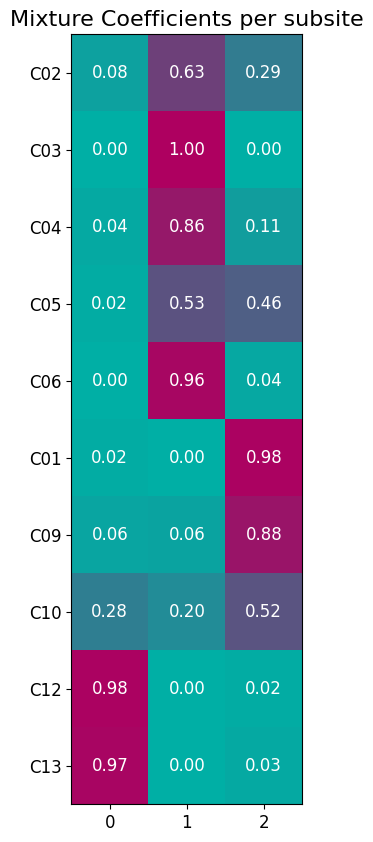

In [119]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)

matrix = mixture.get_mixture_coefs()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]

# Transpose the matrix to rotate by 90°
matrix_rotated = matrix.T

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Display the rotated matrix using imshow
cax = ax.imshow(matrix_rotated.values, cmap=tmp, origin='upper')

# Loop over the data and create text annotations
for i in range(matrix_rotated.shape[0]):  # Rows (previously columns)
    for j in range(matrix_rotated.shape[1]):  # Columns (previously rows)
        value = matrix_rotated.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", 
                color="white", fontsize=12)


# Optional: Set axis labels and title
ax.set_xticks(range(matrix_rotated.shape[1]))
ax.set_xticklabels(matrix.index, fontsize = 12)  # Original row labels
ax.set_yticks(range(matrix_rotated.shape[0]))
ax.set_yticklabels(matrix.columns, fontsize = 12)  # Original column labels
ax.set_title("Mixture Coefficients per subsite", fontsize = 16)
plt.show()


In [89]:
params

{'0_TtoI_spread': 0.034481650210444026,
 '0_TtoII_spread': 0.43443515150616185,
 '0_TtoIII_spread': 0.06979726127783928,
 '0_TtoIV_spread': 0.009904272615126558,
 '0_TtoV_spread': 0.02009794857214547,
 '0_ItoII_spread': 0.6826586949566001,
 '0_IItoIII_spread': 0.10649003669643499,
 '0_IIItoIV_spread': 0.1694673596447928,
 '0_IVtoV_spread': 0.15733992048042078,
 '0_late_p': 0.39071431933395395,
 '0_C01_coef': 0.9999999995331459,
 '0_C02_coef': 0.2942682478240915,
 '0_C03_coef': 1.2657662767035126e-73,
 '0_C04_coef': 0.10074266421077636,
 '0_C05_coef': 0.4656591350917557,
 '0_C06_coef': 1.165940612164696e-24,
 '0_C09_coef': 0.9058128383030442,
 '0_C10_coef': 0.5285358711551943,
 '0_C12_coef': 1.5069130255036644e-13,
 '0_C13_coef': 1.3086537623733853e-06,
 '1_TtoI_spread': 0.061230703520284195,
 '1_TtoII_spread': 0.026578805900061803,
 '1_TtoIII_spread': 0.013842309348332657,
 '1_TtoIV_spread': 0.004070774595678652,
 '1_TtoV_spread': 6.610696135189607e-05,
 '1_ItoII_spread': 0.16394448308

In [42]:
params_history


[{'0_TtoI_spread': 0.034481650210444026,
  '0_TtoII_spread': 0.43443515150616185,
  '0_TtoIII_spread': 0.06979726127783928,
  '0_TtoIV_spread': 0.009904272615126558,
  '0_TtoV_spread': 0.02009794857214547,
  '0_ItoII_spread': 0.6826586949566001,
  '0_IItoIII_spread': 0.10649003669643499,
  '0_IIItoIV_spread': 0.1694673596447928,
  '0_IVtoV_spread': 0.15733992048042078,
  '0_late_p': 0.39071431933395395,
  '0_C01_coef': 0.9999999995331459,
  '0_C02_coef': 0.2942682478240915,
  '0_C03_coef': 1.2657662767035126e-73,
  '0_C04_coef': 0.10074266421077636,
  '0_C05_coef': 0.4656591350917557,
  '0_C06_coef': 1.165940612164696e-24,
  '0_C09_coef': 0.9058128383030442,
  '0_C10_coef': 0.5285358711551943,
  '0_C12_coef': 1.5069130255036644e-13,
  '0_C13_coef': 1.3086537623733853e-06,
  '1_TtoI_spread': 0.061230703520284195,
  '1_TtoII_spread': 0.026578805900061803,
  '1_TtoIII_spread': 0.013842309348332657,
  '1_TtoIV_spread': 0.004070774595678652,
  '1_TtoV_spread': 6.610696135189607e-05,
  '1_It

2d Simplex plot

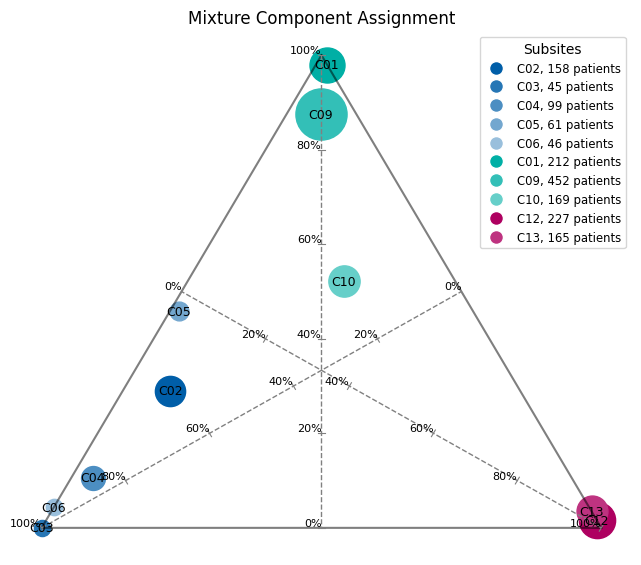

In [120]:
from matplotlib.lines import Line2D
# colormaps
blue_to_white = LinearSegmentedColormap.from_list("blue to white", 
                                                   [usz_blue, "#ffffff"], 
                                                   N=256)
green_to_white = LinearSegmentedColormap.from_list("green_to_white", 
                                                   [usz_green, "#ffffff"], 
                                                   N=256)
red_to_white   = LinearSegmentedColormap.from_list("red_to_white", 
                                                   [usz_red, "#ffffff"], 
                                                   N=256)
orange_to_white   = LinearSegmentedColormap.from_list("orange_to_white", 
                                                   [usz_orange, "#ffffff"], 
                                                   N=256)
colors_ordered= [blue_to_white(0), blue_to_white(0.15), blue_to_white(0.3), blue_to_white(0.45), blue_to_white(0.6), green_to_white(0), green_to_white(0.2), green_to_white(0.4), red_to_white(0), red_to_white(0.2)]  

# Define the plane's normal vector
normal_vector = np.array([1,1,1])/1/np.sqrt(3)

v1 = np.array([1,-1,0])/1/np.sqrt(2)

# Calculate the second orthogonal vector using the cross product
v2 = np.cross(normal_vector, v1) *-1

# Project the point onto the new coordinate system
origin = np.array([0, 1, 0])
x_origin =  origin @ v1
y_origin = origin @ v2

x_vals = matrix.T @ v1 - x_origin
y_vals = matrix.T @ v2 - y_origin

extremes = np.array([[1,0,0],
                    [0,1,0],
                    [0,0,1]])
extremes_x = extremes @ v1 - x_origin
extremes_y = extremes @ v2 - y_origin

# Plot the point in 2D
import matplotlib.pyplot as plt

odered_value_counts = dataset_staging_main_groups['tumor']['1']['subsite'].value_counts()[['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']]
sizes = odered_value_counts * 3

# Define the subsite labels
subsites = ['C02', 'C03', 'C04', 'C05', 'C06', 'C01', 'C09', 'C10', 'C12', 'C13']
plt.figure(figsize=(8, 6.8))
# Plot the points with varying sizes and colors
for i in range(len(x_vals)):
    plt.scatter(x_vals[i], y_vals[i], s=sizes[i], color=colors_ordered[i], label=subsites[i])
    plt.text(x_vals[i], y_vals[i], subsites[i], fontsize=9, ha='center', va='center')

legend_text = []
for index in range(len(subsites)):
    legend_text.append(subsites[index] + ', ' + str(odered_value_counts[index]) + ' patients')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=subsite)
                   for color, subsite in zip(colors_ordered, legend_text)]

# Add a legend with fixed dot sizes
plt.legend(handles=legend_elements, loc='upper right', title='Subsites', fontsize='small')
# plt.scatter(x_vals, y_vals, s=sizes, c = colors_ordered)
# Connect the points
plt.plot(extremes_x, extremes_y, color='black', alpha = 0.5)
# close the triangle by connecting the last point to the first
plt.plot([extremes_x[-1], extremes_x[0]], [extremes_y[-1], extremes_y[0]], color='black', alpha = 0.5)

# Calculate midpoints of each side of the triangle
midpoints_x = (extremes_x[0] + extremes_x[1]) / 2, (extremes_x[1] + extremes_x[2]) / 2, (extremes_x[2] + extremes_x[0]) / 2
midpoints_y = (extremes_y[0] + extremes_y[1]) / 2, (extremes_y[1] + extremes_y[2]) / 2, (extremes_y[2] + extremes_y[0]) / 2

# Draw lines from each vertex to the midpoint of the opposite side
plt.plot([extremes_x[0], midpoints_x[1]], [extremes_y[0], midpoints_y[1]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[1], midpoints_x[2]], [extremes_y[1], midpoints_y[2]], color='gray', linestyle='--', linewidth=1)
plt.plot([extremes_x[2], midpoints_x[0]], [extremes_y[2], midpoints_y[0]], color='gray', linestyle='--', linewidth=1)

# Function to add perpendicular ticks as short lines
def add_perpendicular_ticks(x1, y1, x2, y2, tick_length=0.01):
    num_ticks = 6  # Number of ticks including 0% and 100%
    for i in range(num_ticks):
        t = i / (num_ticks - 1)
        x_tick = x1 + t * (x2 - x1)
        y_tick = y1 + t * (y2 - y1)
        
        # Vector along the line
        dx = x2 - x1
        dy = y2 - y1
        
        # Perpendicular vector
        perp_dx = -dy
        perp_dy = dx
        
        # Normalize the perpendicular vector
        length = np.sqrt(perp_dx**2 + perp_dy**2)
        perp_dx /= length
        perp_dy /= length
        
        # Draw tick as a short perpendicular line
        plt.plot([x_tick - tick_length * perp_dx, x_tick + tick_length * perp_dx], [y_tick - tick_length * perp_dy, y_tick + tick_length * perp_dy], color='gray', linewidth=0.8)
        plt.text(x_tick, y_tick, f'{int(100 - t * 100)}%', fontsize=8, ha='right', va='bottom')

# Add perpendicular ticks to each line with adjusted length
add_perpendicular_ticks(extremes_x[0], extremes_y[0], midpoints_x[1], midpoints_y[1])
add_perpendicular_ticks(extremes_x[1], extremes_y[1], midpoints_x[2], midpoints_y[2])
add_perpendicular_ticks(extremes_x[2], extremes_y[2], midpoints_x[0], midpoints_y[0])



plt.xlabel('u')
plt.ylabel('v')
plt.title('Mixture Component Assignment')
plt.gca().set_axis_off()

plt.show()

In [31]:


legend_text

['C02, 158 patients',
 'C03, 45 patients',
 'C04, 99 patients',
 'C05, 61 patients',
 'C06, 46 patients',
 'C01, 212 patients',
 'C09, 452 patients',
 'C10, 169 patients',
 'C12, 227 patients',
 'C13, 165 patients']